In [6]:
#!/usr/bin/env python
# coding: utf-8

# # Exploratory Data Analysis for Multilingual Summarization Dataset
# 
# This notebook analyzes a HuggingFace dataset for multilingual summarization to understand:
# - Text and summary length distributions
# - Ratio of summary length to text length
# - Language-specific characteristics
# - Potential issues with the data

# ## Import Required Libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from transformers import AutoTokenizer
import re
from tqdm.notebook import tqdm
from tqdm import tqdm as std_tqdm
from collections import Counter

# Enable progress bar for pandas operations
tqdm.pandas()

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# ## Load Dataset

# Replace with your dataset path
DATASET_PATH = "/Data/shash/mul/hf_dataset"  # Update this to your actual path
# List available languages in the dataset directory
languages = [lang for lang in os.listdir(DATASET_PATH) 
             if os.path.isdir(os.path.join(DATASET_PATH, lang)) and lang != ".ipynb_checkpoints"]
print(f"Available languages: {languages}")

# Model we'll use for tokenization (same as fine-tuning model)
MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    print(f"Loaded tokenizer: {MODEL_NAME}")
except:
    print(f"Could not load tokenizer for {MODEL_NAME}. Using a fallback tokenizer.")
    tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m")


Available languages: ['en', 'fr', 'de', 'ja']
Loaded tokenizer: meta-llama/Llama-3.2-1B-Instruct


In [7]:

# ## Define Analysis Functions

def get_token_length(text):
    """Get token length of text using the fine-tuning model's tokenizer"""
    return len(tokenizer.encode(text))

def get_word_length(text):
    """Get approximate word count"""
    return len(text.split())

def get_char_length(text):
    """Get character count"""
    return len(text)

def get_sentence_count(text):
    """Get approximate sentence count"""
    # Simple heuristic for sentence counting
    sentences = re.split(r'[.!?]+', text)
    return len([s for s in sentences if len(s.strip()) > 0])

def calculate_compression_ratio(text_length, summary_length):
    """Calculate compression ratio (text length / summary length)"""
    if summary_length == 0:
        return float('inf')
    return text_length / summary_length

def analyze_dataset(dataset, split="train"):
    """Analyze the dataset and return statistics"""
    
    print(f"Analyzing {split} split...")
    # Convert to pandas for easier analysis
    df = pd.DataFrame(dataset[split])
    
    # Sample data
    print("\nSample data:")
    print(df.head(2).to_string())
    
    # Add length columns
    print("\nCalculating lengths (this may take a while)...")
    
    try:
        # Try using progress_apply if tqdm.pandas() is working
        df['text_tokens'] = df['text'].progress_apply(get_token_length)
        df['summary_tokens'] = df['summary'].progress_apply(get_token_length)
    except AttributeError:
        # Fallback to regular apply with a manual progress bar
        print("Using alternative progress tracking method...")
        texts = df['text'].tolist()
        summaries = df['summary'].tolist()
        
        text_tokens = []
        for text in std_tqdm(texts, desc="Processing text tokens"):
            text_tokens.append(get_token_length(text))
        
        summary_tokens = []
        for summary in std_tqdm(summaries, desc="Processing summary tokens"):
            summary_tokens.append(get_token_length(summary))
            
        df['text_tokens'] = text_tokens
        df['summary_tokens'] = summary_tokens
    
    # Calculate word, character and sentence counts
    df['text_words'] = df['text'].apply(get_word_length)
    df['summary_words'] = df['summary'].apply(get_word_length)
    df['text_chars'] = df['text'].apply(get_char_length)
    df['summary_chars'] = df['summary'].apply(get_char_length)
    df['text_sentences'] = df['text'].apply(get_sentence_count)
    df['summary_sentences'] = df['summary'].apply(get_sentence_count)
    
    # Calculate compression ratios
    df['token_compression_ratio'] = df.apply(
        lambda x: calculate_compression_ratio(x['text_tokens'], x['summary_tokens']), axis=1)
    df['word_compression_ratio'] = df.apply(
        lambda x: calculate_compression_ratio(x['text_words'], x['summary_words']), axis=1)
    
    # Basic stats
    stats = {
        'count': len(df),
        'text_tokens': {
            'mean': df['text_tokens'].mean(),
            'median': df['text_tokens'].median(),
            'std': df['text_tokens'].std(),
            'min': df['text_tokens'].min(),
            'max': df['text_tokens'].max(),
            'p95': df['text_tokens'].quantile(0.95),
            'p99': df['text_tokens'].quantile(0.99),
        },
        'summary_tokens': {
            'mean': df['summary_tokens'].mean(),
            'median': df['summary_tokens'].median(),
            'std': df['summary_tokens'].std(),
            'min': df['summary_tokens'].min(),
            'max': df['summary_tokens'].max(),
            'p95': df['summary_tokens'].quantile(0.95),
            'p99': df['summary_tokens'].quantile(0.99),
        },
        'text_words': {
            'mean': df['text_words'].mean(),
            'median': df['text_words'].median(),
            'min': df['text_words'].min(),
            'max': df['text_words'].max(),
        },
        'summary_words': {
            'mean': df['summary_words'].mean(),
            'median': df['summary_words'].median(),
            'min': df['summary_words'].min(),
            'max': df['summary_words'].max(),
        },
        'compression_ratio': {
            'mean_tokens': df['token_compression_ratio'].mean(),
            'median_tokens': df['token_compression_ratio'].median(),
            'mean_words': df['word_compression_ratio'].mean(),
            'median_words': df['word_compression_ratio'].median(),
        }
    }
    
    return df, stats

def plot_length_distributions(df, language, split="train"):
    """Create visualizations for length distributions"""
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    
    # Text token length distribution
    sns.histplot(df['text_tokens'].clip(upper=df['text_tokens'].quantile(0.99)), 
                 bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(f'{language} - Text Token Length Distribution ({split})')
    axes[0, 0].set_xlabel('Token Count')
    axes[0, 0].axvline(x=1024, color='red', linestyle='--', label='1024 tokens')
    axes[0, 0].axvline(x=2048, color='orange', linestyle='--', label='2048 tokens')
    axes[0, 0].axvline(x=4096, color='green', linestyle='--', label='4096 tokens')
    axes[0, 0].legend()
    
    # Summary token length distribution
    sns.histplot(df['summary_tokens'].clip(upper=df['summary_tokens'].quantile(0.99)), 
                 bins=30, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title(f'{language} - Summary Token Length Distribution ({split})')
    axes[0, 1].set_xlabel('Token Count')
    axes[0, 1].axvline(x=128, color='red', linestyle='--', label='128 tokens')
    axes[0, 1].axvline(x=256, color='orange', linestyle='--', label='256 tokens')
    axes[0, 1].axvline(x=512, color='green', linestyle='--', label='512 tokens')
    axes[0, 1].legend()
    
    # Word count distributions
    sns.histplot(df['text_words'].clip(upper=df['text_words'].quantile(0.99)), 
                 bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f'{language} - Text Word Count Distribution ({split})')
    axes[1, 0].set_xlabel('Word Count')
    
    sns.histplot(df['summary_words'].clip(upper=df['summary_words'].quantile(0.99)), 
                 bins=30, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title(f'{language} - Summary Word Count Distribution ({split})')
    axes[1, 1].set_xlabel('Word Count')
    
    # Compression ratio distribution
    sns.histplot(df['token_compression_ratio'].clip(upper=df['token_compression_ratio'].quantile(0.99)), 
                 bins=30, kde=True, ax=axes[2, 0])
    axes[2, 0].set_title(f'{language} - Token Compression Ratio Distribution ({split})')
    axes[2, 0].set_xlabel('Compression Ratio (text tokens / summary tokens)')
    
    # Scatter plot of text length vs summary length
    sns.scatterplot(x='text_tokens', y='summary_tokens', data=df, ax=axes[2, 1], alpha=0.5)
    axes[2, 1].set_title(f'{language} - Text vs Summary Length ({split})')
    axes[2, 1].set_xlabel('Text Token Count')
    axes[2, 1].set_ylabel('Summary Token Count')
    
    plt.tight_layout()
    return fig

def analyze_summary_content(df, language, split="train", sample_size=100):
    """Analyze summary content patterns"""
    # Take a sample for detailed analysis
    sample = df.sample(min(sample_size, len(df)))
    
    # Check for summaries that are just the first part of the text
    first_part_count = 0
    for _, row in tqdm(sample.iterrows(), total=len(sample), desc="Checking summary patterns"):
        text_start = row['text'][:100].lower().strip()  # First 100 chars
        summary_start = row['summary'][:100].lower().strip() if len(row['summary']) > 0 else ""
        
        # Check if summary begins with the same text as the article
        if summary_start and text_start.startswith(summary_start[:20]) or summary_start.startswith(text_start[:20]):
            first_part_count += 1
    
    print(f"\n{language} - {split}: {first_part_count}/{len(sample)} ({first_part_count/len(sample)*100:.1f}%) "
          f"summaries appear to start with the first part of the text")
    
    # Analyze starting phrases in summaries
    starting_words = []
    for summary in sample['summary']:
        if summary and len(summary.split()) > 0:
            starting_words.append(summary.split()[0].lower())
    
    print("\nMost common summary starting words:")
    for word, count in Counter(starting_words).most_common(10):
        print(f"  {word}: {count} times")
    
    return first_part_count/len(sample)


In [8]:

# ## Main Analysis Loop

all_stats = {}

for language in languages:
    print(f"\n{'='*50}\nAnalyzing language: {language}\n{'='*50}")
    
    # Load dataset for this language
    try:
        dataset = load_from_disk(os.path.join(DATASET_PATH, language))
        print(f"Loaded dataset with splits: {dataset.keys()}")
    except Exception as e:
        print(f"Error loading dataset for {language}: {e}")
        continue
    
    # Analyze each split
    lang_stats = {}
    for split in dataset.keys():
        df, split_stats = analyze_dataset(dataset, split)
        lang_stats[split] = split_stats
        
        # Plot and save distributions
        fig = plot_length_distributions(df, language, split)
        fig.savefig(f"{language}_{split}_distributions.png")
        plt.close(fig)
        
        # Analyze summary content
        copy_ratio = analyze_summary_content(df, language, split)
        lang_stats[split]['copy_first_part_ratio'] = copy_ratio
        
        # Show detailed token length percentiles
        print(f"\nText token length percentiles ({language}, {split}):")
        percentiles = [50, 75, 90, 95, 97, 99]
        for p in percentiles:
            value = df['text_tokens'].quantile(p/100)
            print(f"  {p}%: {value:.1f} tokens")
        
        print(f"\nSummary token length percentiles ({language}, {split}):")
        for p in percentiles:
            value = df['summary_tokens'].quantile(p/100)
            print(f"  {p}%: {value:.1f} tokens")
    
    all_stats[language] = lang_stats

# ## Cross-Language Comparison

# Create comparison dataframes
train_comparison = pd.DataFrame({
    lang: {
        'text_tokens_mean': all_stats[lang]['train']['text_tokens']['mean'],
        'text_tokens_median': all_stats[lang]['train']['text_tokens']['median'],
        'text_tokens_max': all_stats[lang]['train']['text_tokens']['max'],
        'summary_tokens_mean': all_stats[lang]['train']['summary_tokens']['mean'],
        'summary_tokens_median': all_stats[lang]['train']['summary_tokens']['median'],
        'summary_tokens_max': all_stats[lang]['train']['summary_tokens']['max'],
        'compression_ratio': all_stats[lang]['train']['compression_ratio']['median_tokens'],
        'copy_first_part_ratio': all_stats[lang]['train'].get('copy_first_part_ratio', 0)
    } for lang in all_stats
}).T

print("\nCross-language comparison (train split):")
print(train_comparison.to_string())



Analyzing language: en
Loaded dataset with splits: dict_keys(['train', 'validation', 'test'])
Analyzing train split...

Sample data:
   article_id language                  title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/3999 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


en - train: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  the: 28 times
  **summary:**: 3 times
  george: 2 times
  "the: 2 times
  "tokyo: 1 times
  decompression: 1 times
  bolton: 1 times
  trent: 1 times
  chelsea: 1 times
  domestic: 1 times

Text token length percentiles (en, train):
  50%: 19402.0 tokens
  75%: 31471.5 tokens
  90%: 46250.4 tokens
  95%: 57512.6 tokens
  97%: 65365.8 tokens
  99%: 78114.3 tokens

Summary token length percentiles (en, train):
  50%: 166.0 tokens
  75%: 207.0 tokens
  90%: 303.0 tokens
  95%: 400.0 tokens
  97%: 481.1 tokens
  99%: 505.0 tokens
Analyzing validation split...

Sample data:
   article_id language              title                                                                                                                                                                                                                                                                    

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


en - validation: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  the: 32 times
  in: 3 times
  "the: 3 times
  cape: 2 times
  sir: 2 times
  **summary:**: 2 times
  apollonius's: 1 times
  bob: 1 times
  bumblebees,: 1 times
  halley's: 1 times

Text token length percentiles (en, validation):
  50%: 20810.0 tokens
  75%: 31331.0 tokens
  90%: 43025.0 tokens
  95%: 51834.0 tokens
  97%: 60780.0 tokens
  99%: 69898.0 tokens

Summary token length percentiles (en, validation):
  50%: 158.0 tokens
  75%: 200.0 tokens
  90%: 263.0 tokens
  95%: 345.0 tokens
  97%: 391.0 tokens
  99%: 496.0 tokens
Analyzing test split...

Sample data:
   article_id language             title                                                                                                                                                                                                                                                                    

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


en - test: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  the: 28 times
  ernest: 2 times
  hms: 2 times
  "the: 2 times
  batman: 1 times
  winfield: 1 times
  phagocytes: 1 times
  theresa: 1 times
  "wish: 1 times
  "super: 1 times

Text token length percentiles (en, test):
  50%: 20264.0 tokens
  75%: 32420.8 tokens
  90%: 48703.4 tokens
  95%: 57116.2 tokens
  97%: 65808.8 tokens
  99%: 87093.6 tokens

Summary token length percentiles (en, test):
  50%: 166.0 tokens
  75%: 204.0 tokens
  90%: 260.2 tokens
  95%: 380.3 tokens
  97%: 484.0 tokens
  99%: 499.1 tokens

Analyzing language: fr
Loaded dataset with splits: dict_keys(['train', 'validation', 'test'])
Analyzing train split...

Sample data:
   article_id language         title                                                                                                                                                                                              

  0%|          | 0/3999 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (150736 > 131072). Running this sequence through the model will result in indexing errors


  0%|          | 0/3999 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


fr - train: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  le: 20 times
  la: 13 times
  les: 3 times
  l'album: 3 times
  "the: 3 times
  l'article: 2 times
  "le: 2 times
  john: 2 times
  air: 1 times
  "all: 1 times

Text token length percentiles (fr, train):
  50%: 7292.0 tokens
  75%: 17432.0 tokens
  90%: 31237.8 tokens
  95%: 43654.5 tokens
  97%: 53730.6 tokens
  99%: 78289.3 tokens

Summary token length percentiles (fr, train):
  50%: 212.0 tokens
  75%: 254.0 tokens
  90%: 321.0 tokens
  95%: 479.0 tokens
  97%: 501.1 tokens
  99%: 512.0 tokens
Analyzing validation split...

Sample data:
   article_id language      title                                                                                                                                                                                                                                                                                                         

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


fr - validation: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  le: 28 times
  la: 11 times
  les: 3 times
  l'article: 2 times
  un: 2 times
  l'album: 2 times
  gustav: 1 times
  mariah: 1 times
  larry: 1 times
  marvel's: 1 times

Text token length percentiles (fr, validation):
  50%: 7179.0 tokens
  75%: 17458.0 tokens
  90%: 32727.0 tokens
  95%: 40068.0 tokens
  97%: 47980.0 tokens
  99%: 65619.0 tokens

Summary token length percentiles (fr, validation):
  50%: 213.0 tokens
  75%: 255.0 tokens
  90%: 304.0 tokens
  95%: 468.0 tokens
  97%: 505.0 tokens
  99%: 513.0 tokens
Analyzing test split...

Sample data:
   article_id language               title                                                                                                                                                                                                                                                                              

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


fr - test: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  le: 14 times
  la: 11 times
  l'article: 6 times
  les: 5 times
  un: 2 times
  "cris: 1 times
  mana: 1 times
  gerald: 1 times
  djibouti: 1 times
  16: 1 times

Text token length percentiles (fr, test):
  50%: 6966.0 tokens
  75%: 15475.2 tokens
  90%: 25883.0 tokens
  95%: 34506.7 tokens
  97%: 40497.0 tokens
  99%: 48981.7 tokens

Summary token length percentiles (fr, test):
  50%: 212.5 tokens
  75%: 256.0 tokens
  90%: 322.1 tokens
  95%: 473.1 tokens
  97%: 502.0 tokens
  99%: 512.0 tokens

Analyzing language: de
Loaded dataset with splits: dict_keys(['train', 'validation', 'test'])
Analyzing train split...

Sample data:
   article_id language            title                                                                                                                                                                                                          

  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/3999 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


de - train: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  die: 27 times
  der: 10 times
  das: 9 times
  thomas: 2 times
  am: 2 times
  ein: 2 times
  newton: 1 times
  joseph: 1 times
  chester: 1 times
  steven: 1 times

Text token length percentiles (de, train):
  50%: 4755.0 tokens
  75%: 9731.0 tokens
  90%: 18530.4 tokens
  95%: 27293.7 tokens
  97%: 34712.3 tokens
  99%: 52941.1 tokens

Summary token length percentiles (de, train):
  50%: 215.0 tokens
  75%: 285.0 tokens
  90%: 478.0 tokens
  95%: 502.0 tokens
  97%: 508.0 tokens
  99%: 515.0 tokens
Analyzing validation split...

Sample data:
   article_id language    title                                                                                                                                                                                                                                                                                                        

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


de - validation: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  die: 20 times
  der: 20 times
  das: 7 times
  "untitled: 1 times
  joseph-marie: 1 times
  dayton: 1 times
  clindamycin: 1 times
  the: 1 times
  'computer: 1 times
  cedar: 1 times

Text token length percentiles (de, validation):
  50%: 4675.0 tokens
  75%: 9473.0 tokens
  90%: 17304.0 tokens
  95%: 24318.0 tokens
  97%: 29270.0 tokens
  99%: 51600.0 tokens

Summary token length percentiles (de, validation):
  50%: 215.0 tokens
  75%: 281.0 tokens
  90%: 485.0 tokens
  95%: 505.0 tokens
  97%: 508.0 tokens
  99%: 514.0 tokens
Analyzing test split...

Sample data:
   article_id language                  title                                                                                                                                                                                                                                                              

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


de - test: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  der: 22 times
  das: 12 times
  die: 8 times
  edward: 1 times
  fakhruddin: 1 times
  "alien: 1 times
  michael: 1 times
  dying: 1 times
  miley: 1 times
  "ghostbusters: 1 times

Text token length percentiles (de, test):
  50%: 4719.5 tokens
  75%: 9627.8 tokens
  90%: 16444.7 tokens
  95%: 25860.1 tokens
  97%: 34059.0 tokens
  99%: 51711.7 tokens

Summary token length percentiles (de, test):
  50%: 212.5 tokens
  75%: 291.0 tokens
  90%: 492.0 tokens
  95%: 504.0 tokens
  97%: 509.0 tokens
  99%: 514.0 tokens

Analyzing language: ja
Loaded dataset with splits: dict_keys(['train', 'validation', 'test'])
Analyzing train split...

Sample data:
   article_id language       title                                                                                                                                                                                              

  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/3999 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


ja - train: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  ホオアカトキ（学名：geronticus: 1 times
  g3型巡洋戦艦は、第一次世界大戦後、日本とアメリカの艦隊拡張計画に対抗するためにイギリス海軍で設計された巡洋戦艦。計画では4隻が建造される予定だったが、ワシントン海軍軍縮条約により建造が中止された。g3は16インチ砲9門を装備し、32ノットの速力を持つ高速戦艦であった。設計には弩級艦時代の主力艦にはなかった新機軸が取り入れられ、主砲と艦橋構造物が機関スペースの前に集中して置かれていた。装甲は「オール・オア・ナッシング」の考え方で設計され、水中防御システムも採用された。: 1 times
  帝国南極横断探検隊（1914年8月9日〜1917年）は、イギリスが20世紀中に派遣した4番目の南極探検隊で、南極大陸の初横断を目指しましたが失敗しました。探検隊の船が氷に閉じ込められて難破した後、隊長アーネスト・シャクルトンと隊員たちは22ヶ月間にわたり、南極圏で過酷な環境を耐えながら、6名の乗組員が救命艇で1,500キロメートル航海し、全員無事に救助されました。探検は船舶無線が実用化されていたにも関わらず、探検地が遠すぎたため通信ができず、イギリスが第一次世界大戦の真っ最中であったため、捜索・救出は行われませんでした。シャクルトンは過去の探検経験があり、この探検でも科学的な観測を行い、地質学や野生生物の観察を行いました。探検隊の資金は多くの出資者から集められ、最終的に56名が2つのグループに分かれ、エンデュアランス号とオーロラ号に乗船しました。探検隊は南極大陸のケアード海岸に到達しました。探検の多くは映像で記録されています。この探検は数々の書籍や映画、ドキュメンタリー映像作品の題材となっています。この探検は文明圏から何千マイルも離れた地での困難を乗り越えた勇敢な努力として知られています。帝国南極横断探検隊は、シャクルトンの偉業として歴史に残っています。: 1 times
  ミスター・アンダーソン（本名ケネス・アンダーソン）はアメリカのプロレスラーで、ウィスコンシン州グリー

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


ja - validation: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  アブー・マンスール・ニザール・ブン・アル＝ムスタンスィルは、ファーティマ朝のカリフであるムスタンスィルの息子で、1094年から1095年までニザール派のイマームを務めた。彼はカリフの後継者として有力視されていたが、1094年にムスタンスィルが死去した後、宰相のアル＝アフダルはニザールの弟であるムスタアリーをカリフに即位させた。これに反発したニザールはカイロを逃げ出し、アル＝ムスタファー・リッ＝ディーニッラーフの名で反乱を起こしたが、1095年末に敗れて捕らえられ、カイロで監禁され死亡した。その後、ニザール派はファーティマ朝との関係を断ち切り、独自のイマームを擁して発展し、今日に至るまで継承されている。ニザールの生涯は、ファーティマ朝の危機や政治的混乱の影響を受け、その支持者はペルシアとイラクでムスタアリーの継承を認めず、ニザールを正当なイマームとした。この分裂により、ニザール派が形成され、一時期ペルシアで国家を築いた。: 1 times
  フィッシャーは北アメリカに生息するイタチ科の動物で、かつてテン属に属するとされていたが、近年の分子系統研究によりフィッシャー属に属することが判明した。体長は47-75cm、尾長は30-42cmで、魚ではなく陸生の獲物を主に捕食する。ヤマアラシの捕食にも挑む数少ない動物の一つである。: 1 times
  マニアック・マンション:: 1 times
  コマンダン・テストは、フランス海軍が第一次世界大戦後に建造した水上機母艦である。1927年に起工し、1932年に就役した。コマンダン・テストは、地中海艦隊と協力して就役試験を行い、スペイン内戦中には中立船の護衛任務に就いた。第二次世界大戦中は航空機の輸送任務を担当し、1942年にトゥーロン港で自沈した。その後、イタリア軍によって浮揚され、ドイツ軍に鹵獲されたが、連合軍の爆撃により再度沈没した。1950年にスクラップとして売却され、1963年に解体された。: 1 times
  紀元前190年または189年に起こったマグネシアの戦い

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Checking summary patterns:   0%|          | 0/100 [00:00<?, ?it/s]


ja - test: 0/100 (0.0%) summaries appear to start with the first part of the text

Most common summary starting words:
  『ザ・コール: 1 times
  スーパーマリオ64は、任天堂が1996年にnintendo: 1 times
  ウォルト・ディズニーは、1901年12月5日にアメリカ合衆国イリノイ州シカゴで生まれ、1966年12月15日にカリフォルニア州バーバンクで亡くなった。彼はアニメーション作家、アニメーター、プロデューサー、映画監督、脚本家、漫画家、声優、実業家、エンターテイナーとして知られる。ディズニーは「ミッキーマウス」などの世界的に有名なアニメーションキャラクターの生みの親であり、ディズニーリゾートの創立者でもある。彼は兄ロイ・o・ディズニーと共にウォルト・ディズニー・カンパニーを設立し、倒産や失敗を乗り越え、国際的な大企業へと発展させた。ディズニーは多くのアカデミー賞を含む数々の賞を受賞し、アニメーションの分野で大きな影響力を持っていた。彼の一族はアイルランドからの移民で、姓「ディズニー」はノルマン人の祖先から由来する。ディズニーは生涯を通じてアニメーションとエンターテイメント業界に貢献し続けた。この文章は彼の生涯や業績について述べている。詳細はディズニー作品やディズニー家に関する情報も参照のこと。ディズニーの作品は世界中で愛され、彼の遺志は現代のエンターテイメント業界にも引き継がれている。彼の作品はアニメーション技術の進歩とともに、新たな視覚的体験を提供し続けている。彼の功績は、アニメーションだけでなく、テーマパークや映画製作など多岐にわたる。彼の生涯は、困難を乗り越えて成功をつかんだ物語であり、彼の作品は依然として多くの人々に影響を与え続けている。彼の名はエンターテイメントの歴史の中で永遠のものとなっている。ディズニーの名前は現在でも世界中の子供たちや大人たちにとって、夢と魔法の代名詞でありつづけている。彼の作品は世代を超えて愛され、彼の精神は今日もなお多くの人々の心の中に生き: 1 times
  第三次イタリア戦争（1521年-1526年）は、フランスのフランソワ1世と神聖ローマ皇帝カール5世との間で行われた戦争で


RECOMMENDED FINE-TUNING SETTINGS BASED ON ANALYSIS


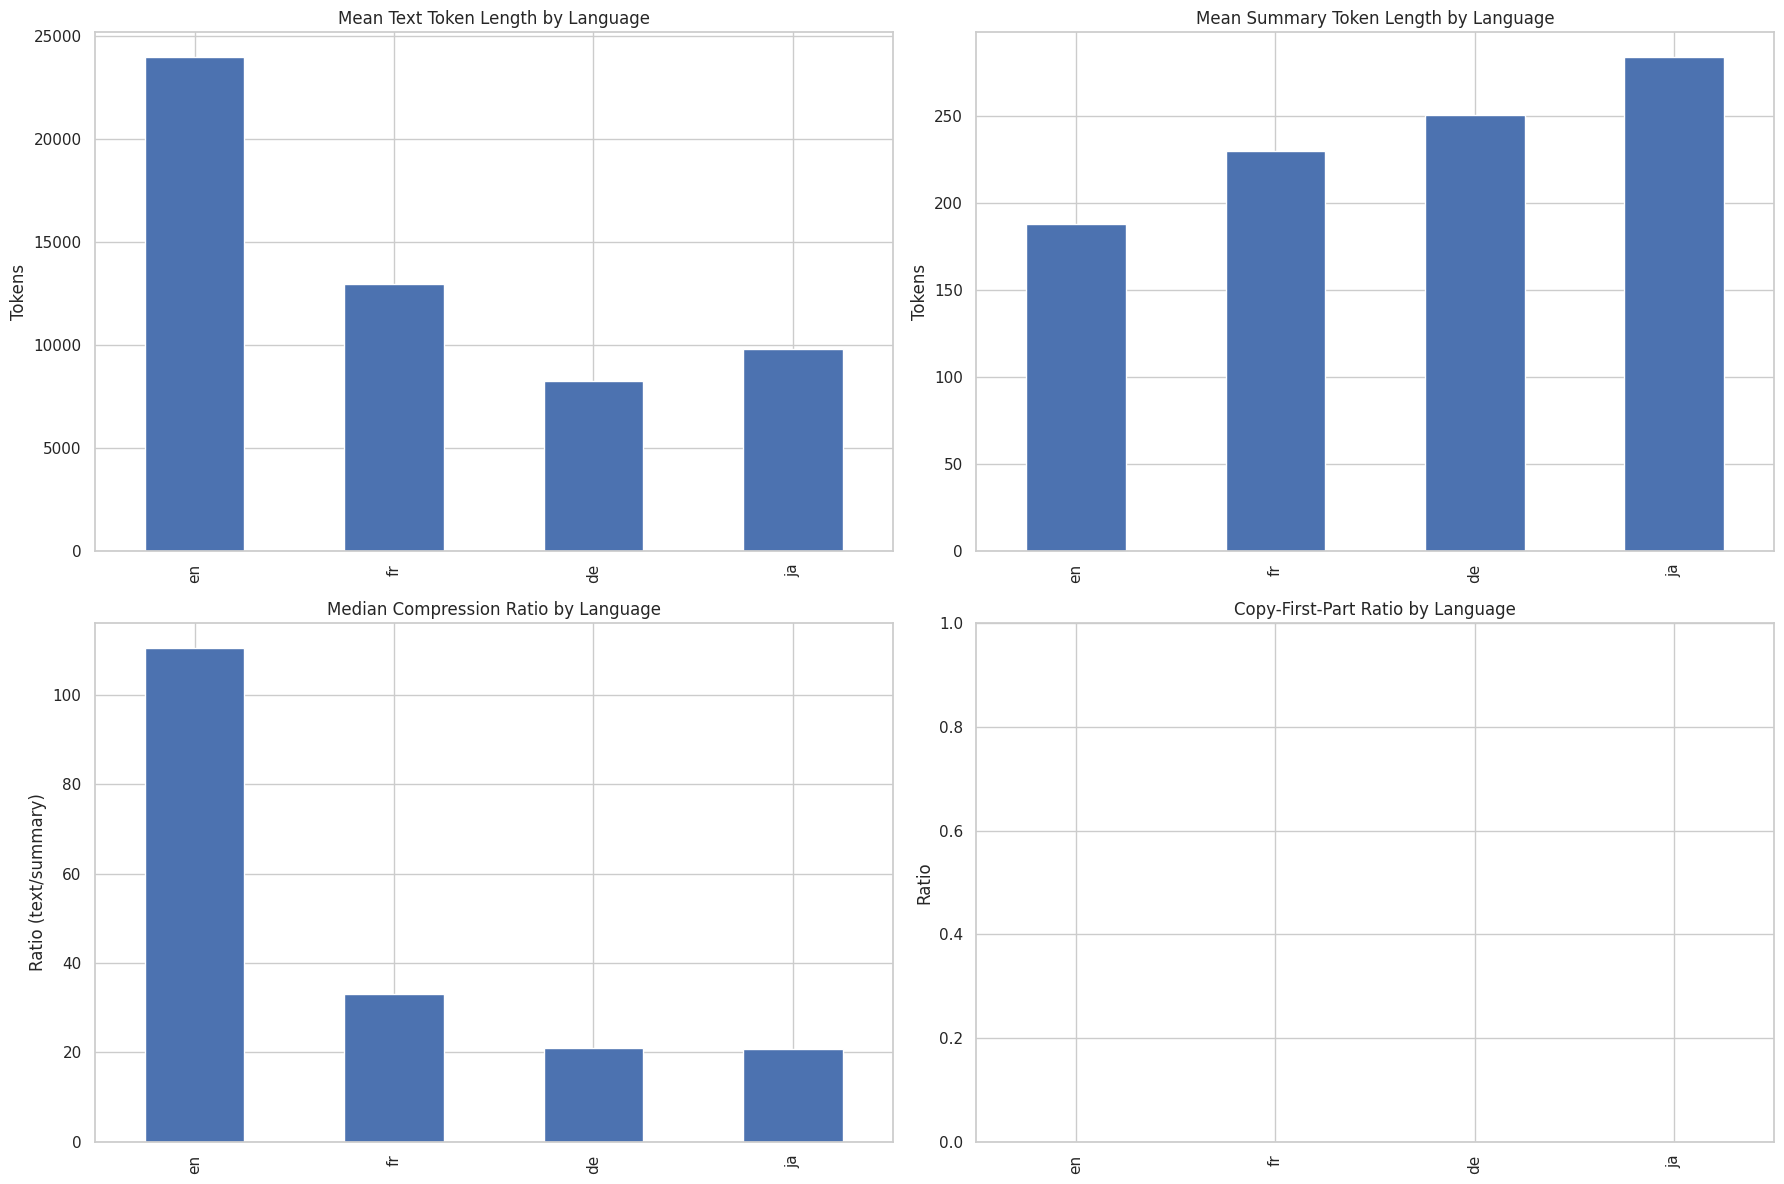

In [9]:

# Plot cross-language comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Text token means by language
train_comparison['text_tokens_mean'].plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Mean Text Token Length by Language')
axes[0, 0].set_ylabel('Tokens')

# Summary token means by language
train_comparison['summary_tokens_mean'].plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Mean Summary Token Length by Language')
axes[0, 1].set_ylabel('Tokens')

# Compression ratios by language
train_comparison['compression_ratio'].plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Median Compression Ratio by Language')
axes[1, 0].set_ylabel('Ratio (text/summary)')

# Copy-first-part ratios by language
train_comparison['copy_first_part_ratio'].plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Copy-First-Part Ratio by Language')
axes[1, 1].set_ylabel('Ratio')
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig("cross_language_comparison.png")

# ## Generate Recommended Settings

print("\n" + "="*80)
print("RECOMMENDED FINE-TUNING SETTINGS BASED ON ANALYSIS")
print("="*80)

In [12]:


# Calculate optimal max lengths based on 95th percentile
max_input_length = int(max([all_stats[lang]['train']['text_tokens']['p95'] for lang in all_stats]) * 1.1)
print('org:', max_input_length)
max_input_length = min(max(max_input_length, 1024), 4096)  # Between 1024 and 4096
# Round to nearest multiple of 128
max_input_length = ((max_input_length + 127) // 128) * 128

max_target_length = int(max([all_stats[lang]['train']['summary_tokens']['p95'] for lang in all_stats]) * 1.1)
max_target_length = min(max(max_target_length, 128), 1024)  # Between 128 and 1024
# Round to nearest multiple of 32
max_target_length = ((max_target_length + 31) // 32) * 32

total_length = max_input_length + max_target_length

print(f"\nRecommended max_input_length: {max_input_length}")
print(f"Recommended max_target_length: {max_target_length}")
print(f"Total sequence length: {total_length}")

compression_ratios = [all_stats[lang]['train']['compression_ratio']['median_tokens'] for lang in all_stats]
avg_compression = sum(compression_ratios) / len(compression_ratios)
print(f"\nAverage compression ratio: {avg_compression:.1f}x")

# Additional recommendations based on analysis
copy_ratios = [all_stats[lang]['train'].get('copy_first_part_ratio', 0) for lang in all_stats]
avg_copy_ratio = sum(copy_ratios) / len(copy_ratios)
print(f"Average copy-first-part ratio: {avg_copy_ratio:.2f}")

if avg_copy_ratio > 0.2:
    print("\n⚠️ WARNING: A significant portion of summaries appear to be copied from the beginning of texts.")
    print("This may explain why your model is simply outputting the first few lines as a summary.")
    print("Consider the following improvements:")
    print("  1. Review your summary generation process")
    print("  2. Filter out examples where summary = first part of text")
    print("  3. Use a better instruction prompt for fine-tuning")
    print("  4. Add negative examples to teach the model NOT to copy the first part")

print("\nAdditional recommendations:")
print("  1. Batch size: 4-8 (depending on GPU memory)")
print(f"  2. Gradient accumulation steps: {max(1, 32 // 4)}") # Aim for effective batch size of ~32
print("  3. Learning rate: 2e-4 to 5e-4 with cosine scheduling")
print("  4. Training epochs: 3-5")
print("  5. Improve the instruction prompt in your fine-tuning data")
print("  6. Consider using a larger model if possible (3B-7B parameters)")

print("\nSuggested improved prompt template:")
print("""### Instruction:
Write a comprehensive and concise summary of the following text. Focus on the main points and important details. Do not simply copy the first few sentences of the text. The summary should be self-contained and understandable without reading the original text.

### Input:
{text}

### Response:
{summary}""")

org: 63263

Recommended max_input_length: 4096
Recommended max_target_length: 576
Total sequence length: 4672

Average compression ratio: 46.3x
Average copy-first-part ratio: 0.00

Additional recommendations:
  1. Batch size: 4-8 (depending on GPU memory)
  2. Gradient accumulation steps: 8
  3. Learning rate: 2e-4 to 5e-4 with cosine scheduling
  4. Training epochs: 3-5
  5. Improve the instruction prompt in your fine-tuning data
  6. Consider using a larger model if possible (3B-7B parameters)

Suggested improved prompt template:
### Instruction:
Write a comprehensive and concise summary of the following text. Focus on the main points and important details. Do not simply copy the first few sentences of the text. The summary should be self-contained and understandable without reading the original text.

### Input:
{text}

### Response:
{summary}


In [11]:


# ## Save all statistics for reference
import json
with open('dataset_statistics.json', 'w') as f:
    # Convert stats to serializable format
    serializable_stats = {}
    for lang, lang_stats in all_stats.items():
        serializable_stats[lang] = {}
        for split, split_stats in lang_stats.items():
            serializable_stats[lang][split] = {}
            for key, value in split_stats.items():
                if isinstance(value, dict):
                    serializable_stats[lang][split][key] = {k: float(v) for k, v in value.items()}
                elif isinstance(value, (int, float)):
                    serializable_stats[lang][split][key] = float(value)
                else:
                    serializable_stats[lang][split][key] = value
                    
    json.dump(serializable_stats, f, indent=2)